In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gene_panel_selection import ExpressionDataset, ScranMethod, GeneBasisMethod, GenePanelSelection, gene_basis_panel_eval, norm_confusion_matrix

In [2]:
directory = '//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/'

In [25]:
# load data

annotations = pd.read_feather(directory + 'subcortical_rnaseq_subset/anno.feather').set_index('sample_id')
expression = pd.read_feather(directory + 'subcortical_rnaseq_subset/expression_matrix_log_cpm_normalized.feather').set_index('gene')

exp_data = ExpressionDataset(
    expression_data=expression,  # dataframe, one gene per row, index is gene names, columns are samples
    annotation_data=annotations,  # dataframe, index is sample names, has columns 'cluster', 'subclass', 'class'
    save_path = directory, # path to save to for later recall
    logcounts = True, # log counts were already computed
    region = 'basal ganglia'
)

gene panel UID: 1651867229.391


In [28]:
exp_data.annotation_data.head()

,class,subclass,cluster,supertype
sample_id,,,,
AAACGCGCACAATTAC-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3
AACCTAATCCCTGTTA-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_SST-NPY,IN_Str_SST
AACCTCCTCAATCTCT-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3
AAGAATCAGCCACAAT-L8XR_210812_01_A11-1124987480,MSN,D1-MSN,D1-Icj,D1-Icj
AATGCGCGTGATTTGG-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3


In [29]:
# pre-select highly variable genes
hvg_selection = ScranMethod(exp_data=exp_data).select_gene_panel(size=None, args={})

In [30]:
hvg_selection.report()

{'n_genes_selected': 8207, 'variance_threshold': 0, 'used_log_counts': True, 'file_name': 'hvg_selection'}


In [31]:
hvg_exp_data = hvg_selection.expression_dataset()

In [32]:
# geneBasis gene selection
# first convert to SCE format

gene_basis = GeneBasisMethod(exp_data=hvg_exp_data)

gene_basis.df_to_sce()

saving expression and annotation data to csv...
converting data to SCE format...
Counts matrix is being processed.
Meta file is being processed.


In [33]:
# select genes

final_selection = gene_basis.select_gene_panel(size=140)

Constructing the True graph.
True graph is constructed.
First gene is added: TCF4. 139 left.
New gene is added: ERBB4. 138 left.
New gene is added: ADARB2. 137 left.
New gene is added: GRIK2. 136 left.
New gene is added: ST18. 135 left.
New gene is added: PRKG1. 134 left.
New gene is added: PDE1C. 133 left.
New gene is added: NXPH1. 132 left.
New gene is added: LUZP2. 131 left.
New gene is added: GPC6. 130 left.
New gene is added: NRG3. 129 left.
New gene is added: GPC5. 128 left.
New gene is added: GRIK1. 127 left.
New gene is added: UNC5D. 126 left.
New gene is added: NELL1. 125 left.
New gene is added: BMPR1B. 124 left.
New gene is added: ZMAT4. 123 left.
New gene is added: FOXP2. 122 left.
New gene is added: SNTG2. 121 left.
New gene is added: SLC9B1. 120 left.
New gene is added: KIRREL3. 119 left.
New gene is added: PTPRT. 118 left.
New gene is added: NKAIN2. 117 left.
New gene is added: XIRP2. 116 left.
New gene is added: DPP10. 115 left.
New gene is added: MAN1A1. 114 left.
New 

In [3]:
final_selection = GenePanelSelection.load_gene_panel_selection(directory=directory, 
                                                               timestamp='1651867229.391', 
                                                               filename='gene_panel_selection')

In [5]:
final_selection.report()

{'n_genes_selected': 140, 'used_log_counts': True, 'file_name': 'gene_panel_selection'}


In [4]:
gene_basis_eval = gene_basis_panel_eval(final_selection)

saving expression and annotation data to csv...
//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/1651867229.391\expression_data.csv already exists
//allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/gene_panel_runs/1651867229.391\annotation_data.csv already exists
converting data to SCE format...
Counts matrix is being processed.
Meta file is being processed.
Calculating cell neighborhood preservation scores.
Finished for the selection of 140 genes.
Finished calculation of cell neighborhood preservation scores.
Performing celltype mapping
Level: class
Level: subclass
Level: cluster


In [5]:
neighborhood_score, fraction_mapped, confusion_matrix = gene_basis_eval

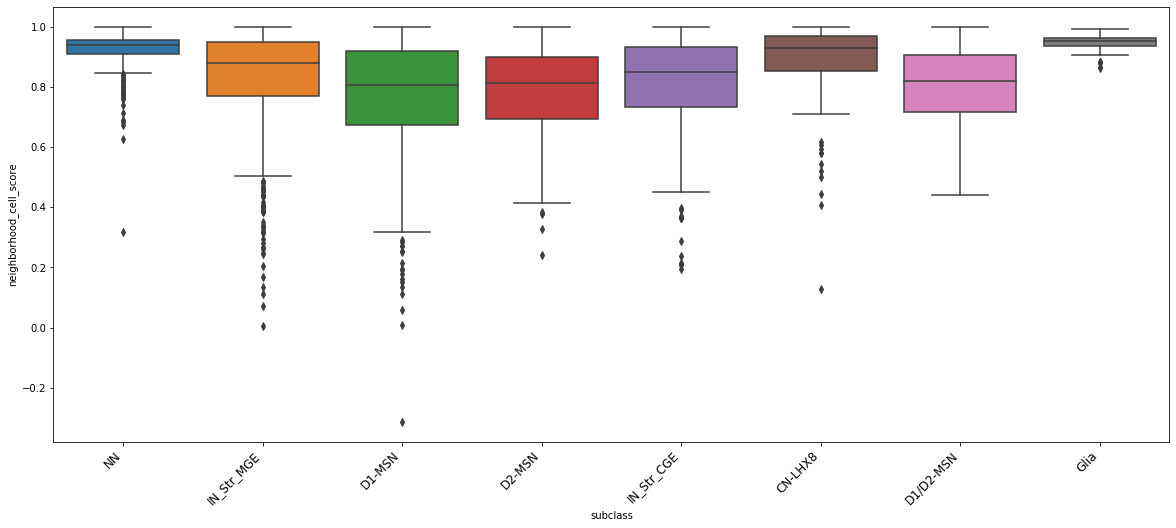

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=neighborhood_score, x='subclass', y='neighborhood_cell_score', ax=ax)
_ = plt.xticks(rotation = 45, fontsize=12, ha='right')

In [7]:
neighborhood_score.describe()

,neighborhood_cell_score
count,3100.000000
mean,0.825984
std,0.160545
min,-0.314559
25%,0.750663
50%,0.878521
75%,0.945026
max,1.000000


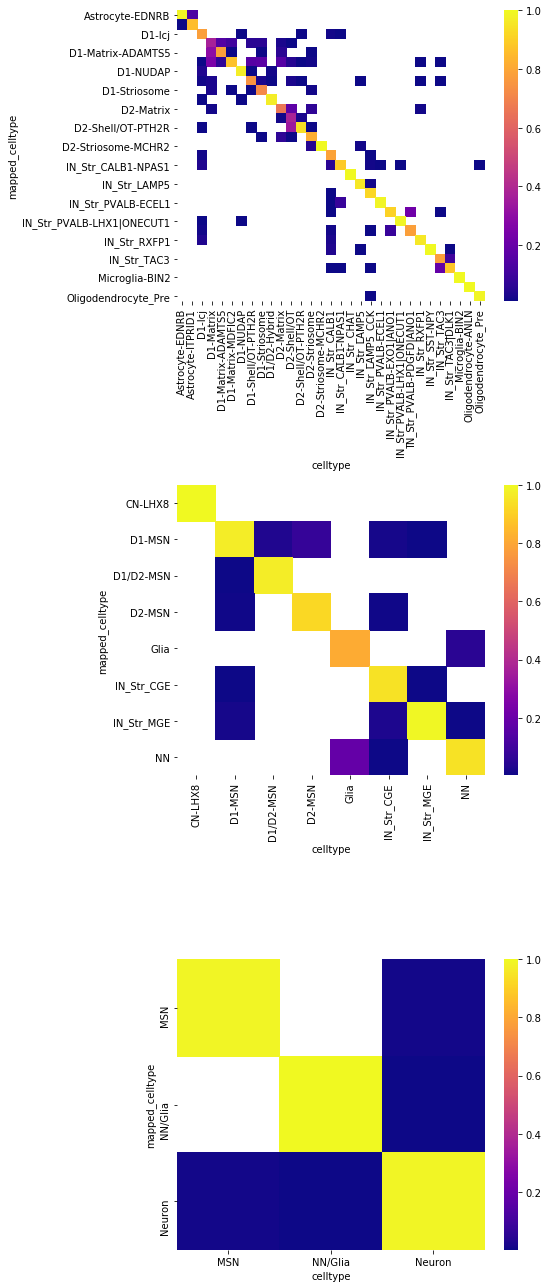

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(8, 18))

norm_conf_matrix = norm_confusion_matrix(confusion_matrix)                       
for i, level in enumerate(['cluster', 'subclass', 'class']):
    sns.heatmap(norm_conf_matrix[level].dropna(how='all'), cmap='plasma', vmax=1, ax=ax[i], )
plt.tight_layout()

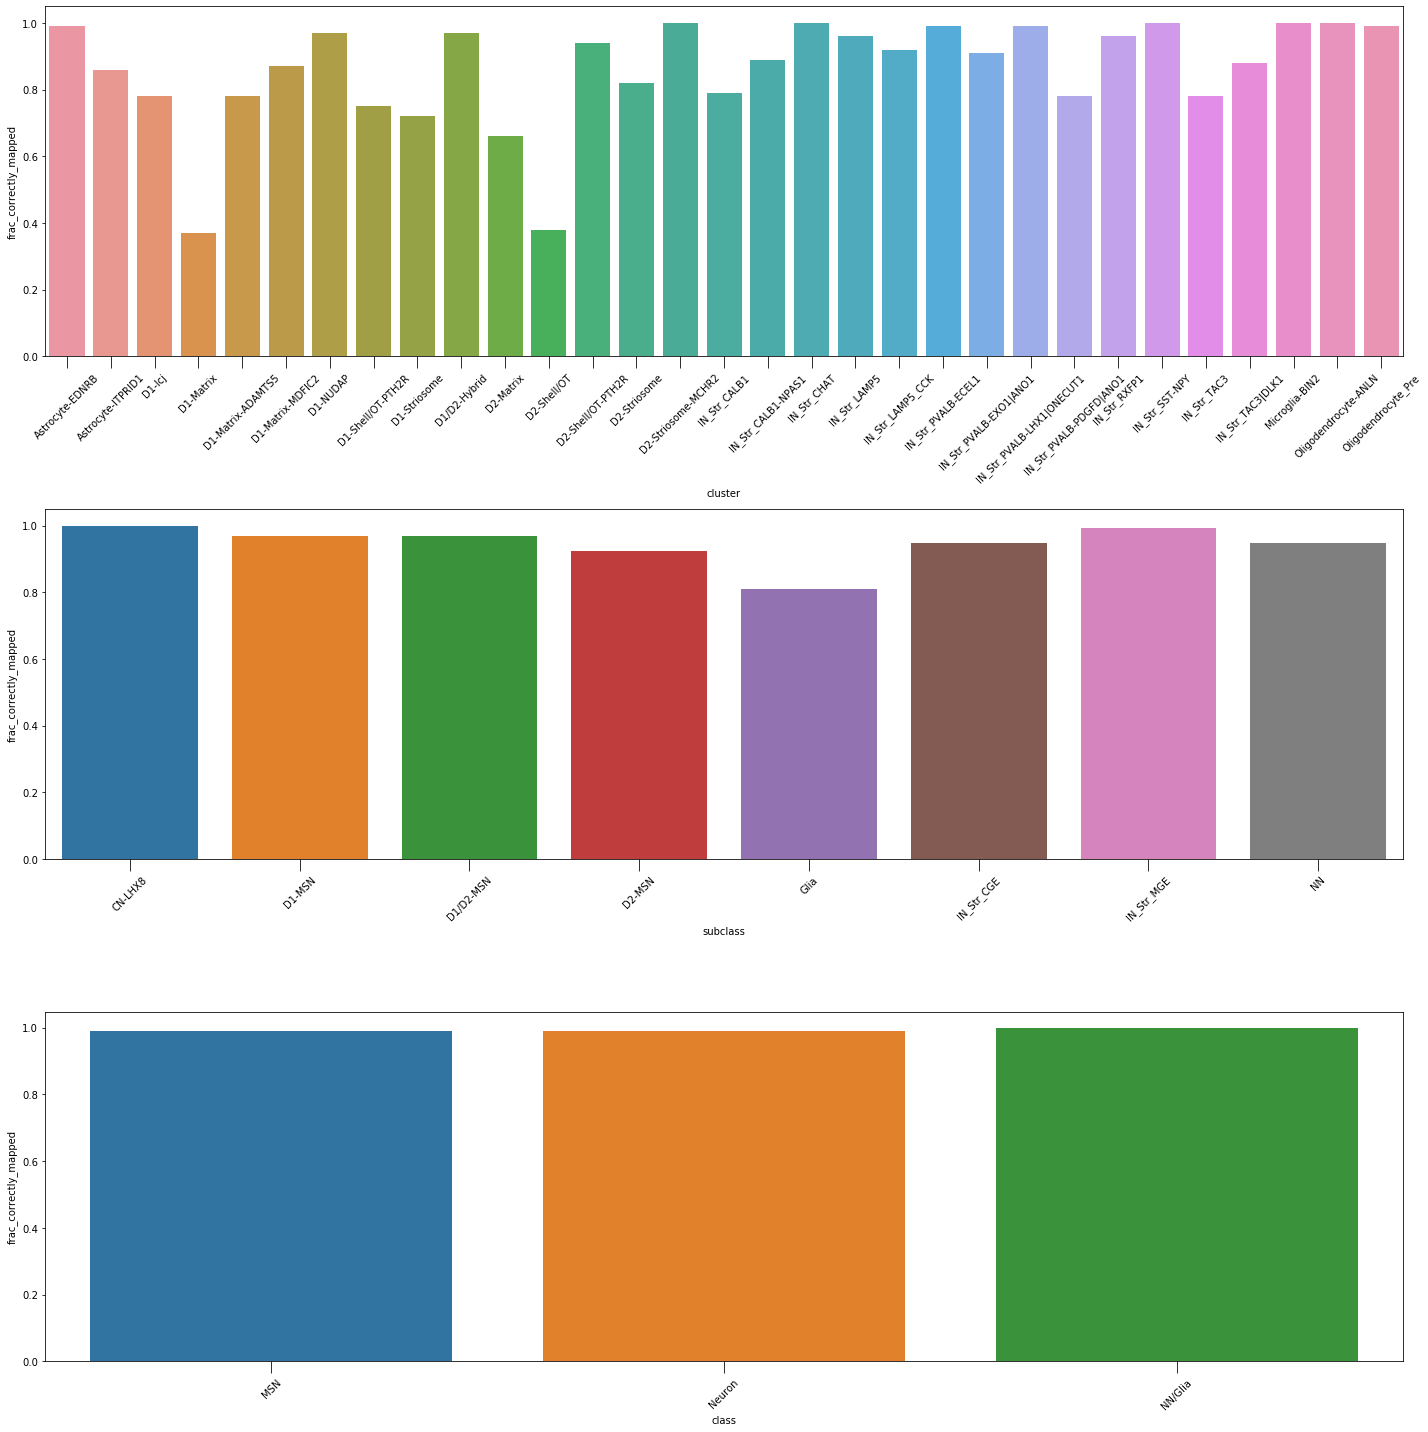

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

for i, level in enumerate(['cluster', 'subclass', 'class']):
    sns.barplot(data=fraction_mapped[level].dropna(how='all'), x='celltype', y='frac_correctly_mapped', ax=ax[i])
    ax[i].set_xlabel(level)
    ax[i].tick_params(axis='x', rotation = 45, size=12)
plt.tight_layout()

In [13]:
shiny_dir = '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_20220104/'

In [ ]:
data = pd.read_feather(shiny_dir + 'data.feather')
data.head()

In [7]:
len(data)

81525

In [14]:
anno = pd.read_feather(shiny_dir + 'anno.feather')
anno.head()

,sample_name,orig.ident_id,orig.ident_label,orig.ident_color,nUMI_id,nUMI_label,nUMI_color,nGene_id,nGene_label,nGene_color,...,MTG_corr_color,sample_id,ar_id,reference_id,cell_id,revised_subclass_labeling,revised_cluster_labeling,tabled.revised_subclass_labeling,tabled.revised_cluster_labeling,cluster
0,M1XM_210806_151-R_A01,1,SeuratProject,#FF7373,22257,30220.0,#B2B2DC,4388,5391.0,#FFC5C5,...,#CC1FA8,AAACAGCCAGCTTAAT-L8XR_210812_01_A11-1124987480,1124987480,1134913634,1122767954,D2-Matrix,D2-Matrix,|D2-Matrix (0.73)|D2-Striosome (0.22)|D2-Shell...,|D2-Matrix (0.73)|D2-Striosome (0.22)|D2-Shell...,1.0
1,M1XM_210806_151-R_A01,1,SeuratProject,#FF7373,4494,6098.0,#1D1D98,1290,2289.0,#5B5BB4,...,#CC5C69,AAACAGCCAGGCGATA-L8XR_210812_01_A11-1124987480,1124987480,1134913634,1122767954,Oligos,Oligos,|Oligos (0.77)|Oligodendrocyte (0.22)|DRD1 (0)|,|Oligos (0.63)|Oligo/OPC - GPe+ (0.36)|DRD1 (0)|,15.0
2,M1XM_210806_151-R_A01,1,SeuratProject,#FF7373,2245,3846.0,#0F0F91,704,1703.0,#3131A1,...,#FF003A,AAACAGCCAGGCTACT-L8XR_210812_01_A11-1124987480,1124987480,1134913634,1122767954,Microglia,Microglia,|Microglia (0.99)|DRD2 (0.01)|Astrocyte (0)|,|Microglia (0.99)|DRD2 (0.01)|[X] SOX6 / MSN_D...,24.0
3,M1XM_210806_151-R_A01,1,SeuratProject,#FF7373,10898,12616.0,#4545AA,2569,3568.0,#B6B6DE,...,#45995B,AAACATGCAATCTCTC-L8XR_210812_01_A11-1124987480,1124987480,1134913634,1122767954,IN_Striatum,IN_str_CCK+ (VIP),|IN_Striatum (0.4)|OPC (0.27)|DRD1 (0.12)|,|IN_str_CCK+ (VIP) (0.34)|IN_str_CCK (OTX2) - ...,52.0
4,M1XM_210806_151-R_A01,1,SeuratProject,#FF7373,19396,23249.0,#8787C8,3386,4385.0,#F0F0F8,...,#FF4DEE,AAACCAACAGTAGCCT-L8XR_210812_01_A11-1124987480,1124987480,1134913634,1122767954,IN_Striatum,IN_str_SST Chodl (NPY) - Str/GP,|IN_Striatum (0.55)|OPC (0.23)|IN_CALB1 (0.14)|,|IN_str_SST Chodl (NPY) - Str/GP (0.69)|IN_CAL...,37.0


In [15]:
cols = [
    'sample_id',
    'class_label',
    'subclass_label',
    'celltype_label',
    'supertype_label',
    'roi_label'
       ]

anno_reduced = anno[cols]
anno_reduced.head(10)

,sample_id,class_label,subclass_label,celltype_label,supertype_label,roi_label
0,AAACAGCCAGCTTAAT-L8XR_210812_01_A11-1124987480,MSN,D2-MSN,D2-Matrix,D2-Matrix,Macaque CaH
1,AAACAGCCAGGCGATA-L8XR_210812_01_A11-1124987480,NN/Glia,NN,Oligodendrocyte-ANLN,Oligodendrocyte,Macaque CaH
2,AAACAGCCAGGCTACT-L8XR_210812_01_A11-1124987480,NN/Glia,Glia,Microglia-BIN2,Microglia,Macaque CaH
3,AAACATGCAATCTCTC-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_CGE,IN_Str_LAMP5_CCK,IN_Str_VIP,Macaque CaH
4,AAACCAACAGTAGCCT-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_SST-NPY,IN_Str_SST,Macaque CaH
5,AAACCGAAGAGAAGGG-L8XR_210812_01_A11-1124987480,NN/Glia,NN,Oligodendrocyte-ANLN,Oligodendrocyte,Macaque CaH
6,AAACCGAAGCTGAGGG-L8XR_210812_01_A11-1124987480,NN/Glia,NN,Oligodendrocyte-ANLN,Oligodendrocyte,Macaque CaH
7,AAACCGAAGTTGGCCA-L8XR_210812_01_A11-1124987480,NN/Glia,NN,Oligodendrocyte-ANLN,Oligodendrocyte,Macaque CaH
8,AAACCGCGTAATCGGC-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3,Macaque CaH
9,AAACCGCGTGAAACAA-L8XR_210812_01_A11-1124987480,NN/Glia,NN,Astrocyte-EDNRB,Astrocyte,Macaque CaH


In [16]:
anno_reduced['roi_label'].unique()

array(['Macaque CaH', 'Macaque CaB', 'Macaque PuR', 'Macaque CaT',
       'Macaque PuPV', 'Macaque PuC', 'Macaque GPi', 'Macaque GPe'],
      dtype=object)

In [23]:
anno_reduced.groupby('celltype_label').count()

,sample_id,class_label,subclass_label,supertype_label
celltype_label,,,,
Astrocyte-EDNRB,2000,2000,2000,2000
Astrocyte-ITPRID1,2000,2000,2000,2000
D1-Icj,485,485,485,485
D1-Matrix,10000,10000,10000,10000
D1-Matrix-ADAMTS5,2000,2000,2000,2000
D1-Matrix-MDFIC2,2000,2000,2000,2000
D1-NUDAP,608,608,608,608
D1-Shell/OT-PTH2R,2000,2000,2000,2000
D1-Striosome,5370,5370,5370,5370


In [26]:
all_cells = anno_reduced[anno_reduced['celltype_label']=='D1-Matrix']['sample_id'].to_list()

In [28]:
len(all_cells)

10000

In [29]:
import random

cells_100 = random.sample(all_cells, 100)

In [31]:
import random

clusters = anno_reduced['celltype_label'].unique()
cell_subset = []
for cluster in clusters:
    all_cells = anno_reduced[anno_reduced['celltype_label']==cluster]['sample_id'].to_list()
    cells_100 = random.sample(all_cells, 100)
    cell_subset.extend(cells_100)

In [16]:
anno_subset = anno_reduced[anno_reduced['sample_id'].isin(cell_subset)].reset_index(drop=True)
anno_subset = anno_subset.rename(columns={'class_label': 'class', 'subclass_label': 'subclass', 'celltype_label': 'cluster', 'supertype_label': 'supertype'})
anno_subset.head()

NameError: name 'anno_reduced' is not defined

In [23]:
anno = exp_data.annotation_data.reset_index()
anno = anno.rename(columns={'cell': 'sample_id','class_label': 'class', 'subclass_label': 'subclass', 'celltype_label': 'cluster', 'supertype_label': 'supertype'})
anno.head()

,sample_id,class,subclass,cluster,supertype
0,AAACGCGCACAATTAC-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3
1,AACCTAATCCCTGTTA-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_SST-NPY,IN_Str_SST
2,AACCTCCTCAATCTCT-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3
3,AAGAATCAGCCACAAT-L8XR_210812_01_A11-1124987480,MSN,D1-MSN,D1-Icj,D1-Icj
4,AATGCGCGTGATTTGG-L8XR_210812_01_A11-1124987480,Neuron,IN_Str_MGE,IN_Str_TAC3,IN_Str_TAC3


In [24]:
anno.to_feather(directory + '/subcortical_rnaseq_subset/anno.feather')

In [88]:
expression_subset = data[data['sample_id'].isin(cell_subset)].reset_index(drop=True).set_index('sample_id')
expression_subset.rename_axis(None, axis=0, inplace=True)
expression_subset = expression_subset.transpose()
expression_subset.index.rename('gene', inplace=True)
expression_subset.reset_index(inplace=True)

In [89]:
# expression_subset.index.rename('gene', inplace=True)
expression_subset.head()

,gene,AAACGCGCACAATTAC-L8XR_210812_01_A11-1124987480,AACCTAATCCCTGTTA-L8XR_210812_01_A11-1124987480,AACCTCCTCAATCTCT-L8XR_210812_01_A11-1124987480,AAGAATCAGCCACAAT-L8XR_210812_01_A11-1124987480,AATGCGCGTGATTTGG-L8XR_210812_01_A11-1124987480,AATTTGCCAATGCGCT-L8XR_210812_01_A11-1124987480,ACAAAGGTCCGGGACT-L8XR_210812_01_A11-1124987480,ACAACACTCTAGCGTG-L8XR_210812_01_A11-1124987480,ACACCTTGTATCTGGA-L8XR_210812_01_A11-1124987480,...,TTATAGCCAGCGCTTG-L8XR_210909_02_C09-1132816395,TTCCTTGAGCCAAATC-L8XR_210909_02_C09-1132816395,TTCGGTACATAAGGAC-L8XR_210909_02_C09-1132816395,TTGACATCAATTAGCT-L8XR_210909_02_C09-1132816395,TTGCAATCAATAATCC-L8XR_210909_02_C09-1132816395,TTGCTTAGTATTTGCC-L8XR_210909_02_C09-1132816395,TTGTGCGAGTGACCTG-L8XR_210909_02_C09-1132816395,TTGTGTGCACTTAACG-L8XR_210909_02_C09-1132816395,TTTCCTGAGCAATAGG-L8XR_210909_02_C09-1132816395,TTTGCATTCACCATTT-L8XR_210909_02_C09-1132816395
0,5-8S-rRNA,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,5-8S-rRNA ENSMMUG00000025378,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,5-8S-rRNA ENSMMUG00000049815,0.0,3.307211,0.0,0.0,0.0,0.0,0.0,0.0,4.042564,...,0.0,0.0,0.0,4.887178,0.0,0.0,0.0,0.0,0.0,0.0
3,5S-rRNA ENSMMUG00000026323,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5S-rRNA ENSMMUG00000026646,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
expression_subset.to_feather(directory + '/subcortical_rnaseq_subset/expression_matrix_log_CPM_normalized.feather')


In [91]:
pd.read_feather(directory + '/subcortical_rnaseq_subset/expression_matrix_log_CPM_normalized.feather')

,gene,AAACGCGCACAATTAC-L8XR_210812_01_A11-1124987480,AACCTAATCCCTGTTA-L8XR_210812_01_A11-1124987480,AACCTCCTCAATCTCT-L8XR_210812_01_A11-1124987480,AAGAATCAGCCACAAT-L8XR_210812_01_A11-1124987480,AATGCGCGTGATTTGG-L8XR_210812_01_A11-1124987480,AATTTGCCAATGCGCT-L8XR_210812_01_A11-1124987480,ACAAAGGTCCGGGACT-L8XR_210812_01_A11-1124987480,ACAACACTCTAGCGTG-L8XR_210812_01_A11-1124987480,ACACCTTGTATCTGGA-L8XR_210812_01_A11-1124987480,...,TTATAGCCAGCGCTTG-L8XR_210909_02_C09-1132816395,TTCCTTGAGCCAAATC-L8XR_210909_02_C09-1132816395,TTCGGTACATAAGGAC-L8XR_210909_02_C09-1132816395,TTGACATCAATTAGCT-L8XR_210909_02_C09-1132816395,TTGCAATCAATAATCC-L8XR_210909_02_C09-1132816395,TTGCTTAGTATTTGCC-L8XR_210909_02_C09-1132816395,TTGTGCGAGTGACCTG-L8XR_210909_02_C09-1132816395,TTGTGTGCACTTAACG-L8XR_210909_02_C09-1132816395,TTTCCTGAGCAATAGG-L8XR_210909_02_C09-1132816395,TTTGCATTCACCATTT-L8XR_210909_02_C09-1132816395
0,5-8S-rRNA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5-8S-rRNA ENSMMUG00000025378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5-8S-rRNA ENSMMUG00000049815,0.000000,3.307211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.042564,...,0.000000,0.0,0.000000,4.887178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5S-rRNA ENSMMUG00000026323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5S-rRNA ENSMMUG00000026646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15875,ZYG11A,0.000000,0.000000,4.891464,0.000000,4.795235,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,4.925252,0.000000,4.370412,0.000000,0.000000,0.000000,0.000000,0.000000
15876,ZYG11B,4.435271,4.665658,5.447856,4.193350,4.795235,6.019012,0.000000,0.000000,4.042564,...,4.824571,0.0,4.925252,0.000000,5.460558,5.867021,0.000000,0.000000,5.772878,0.000000
15877,ZYX,0.000000,3.307211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.971662,0.000000,5.082836,0.000000
15878,ZZEF1,4.435271,3.981880,5.803239,5.972450,0.000000,0.000000,0.000000,6.342726,5.819589,...,0.000000,0.0,0.000000,4.887178,5.057216,5.867021,0.000000,5.321988,0.000000,6.049761
